# Fruits Classification Model

# Download the Datasets from web

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz

# Uncompress the datasets

import tarfile

def extract_tar_gz(file_path, extract_dir):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

extract_tar_gz("/kaggle/working/fruits_dataset.tar.gz", '/kaggle/working')

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100), validation_split = 0.25,
                                subset = "training", seed = 417)

validation_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100), validation_split = 0.25,
                                subset = "validation", seed = 417)

test_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/test",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100))

Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


In [3]:
# Rescaling an input

normalization_layer = tf.keras.layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

In [4]:
train_set_elem = train_set_normalized.take(1)

images = None
for image_batch, label_batch in train_set_elem:
  images = image_batch.numpy()

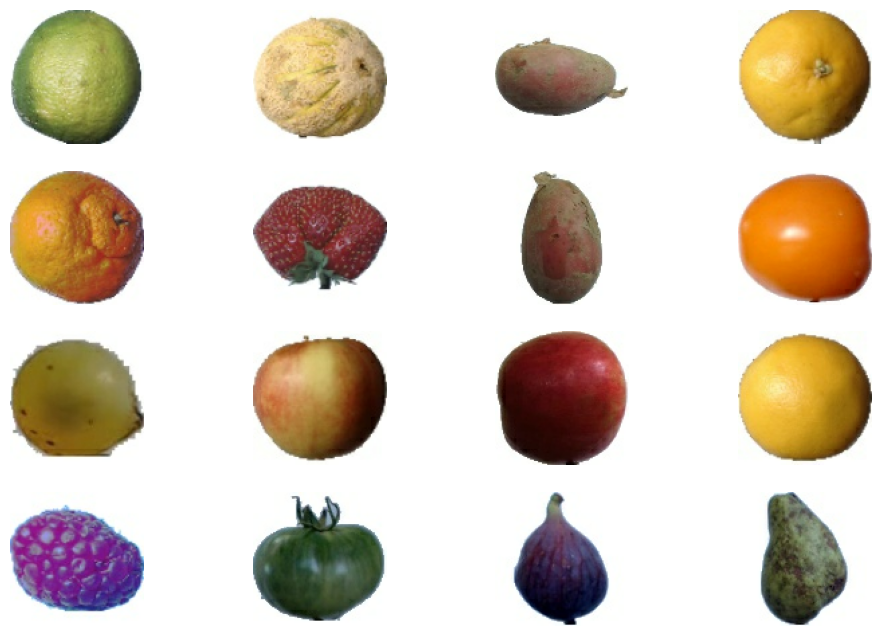

In [5]:
# visualization of 16 images from batch 1

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

# Residual Neural Network (ResNets)

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization

weight_initializer = tf.keras.initializers.HeNormal(seed=417)

def resnet_block(input_layer, num_filters):
    shortcut = input_layer
    output = Conv2D(filters = num_filters, kernel_size = (3, 3), activation = "relu",
                    kernel_initializer = weight_initializer, padding = "same",strides = 1)(input_layer)
    output = BatchNormalization()(output)
    output = tf.keras.layers.ReLU()(output)
    output = Conv2D(filters = num_filters, kernel_size = (3, 3), activation = "relu",
                    kernel_initializer = weight_initializer, padding = "same",strides = 1)(output)
    output = BatchNormalization()(output)
    output = tf.keras.layers.Add()([output, shortcut])
    output = tf.keras.layers.ReLU()(output)
    return output

In [7]:
from tensorflow.keras import Model,Input

# things to note:
# The input parameters reprsent image_size (100,100) and
# the channel dimension (3) i.e Red, Green, Yellow in the data. Grayscale has 1

def resnet18(num_classes):
    input_layer = Input(shape= (100,100,3))
    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7),kernel_initializer = weight_initializer,
                    padding = "same",strides = 2)(input_layer)
    conv = BatchNormalization()(conv)
    conv = tf.keras.layers.ReLU()(conv)
    conv = MaxPooling2D(pool_size=(3, 3), strides= 2, padding="same")(conv)
    block1 = resnet_block(conv, 64)
    block2 = resnet_block(block1, 64)
    global_pooling = tf.keras.layers.GlobalAveragePooling2D()(block2)
    output = Dense(num_classes)(global_pooling)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

In [8]:
model = resnet18(131)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 50, 50,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 25,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 25, 25,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_4[0][0]  

 Total params: 166,979 (652.26 KB)

 Trainable params: 166,339 (649.76 KB)

 Non-trainable params: 640 (2.50 KB)

# ResNets II: Adding More Residual Blocks

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model,Input

weight_initializer = tf.keras.initializers.HeNormal(seed=417)

def resnet_block(input_layer, num_filters, downsample = False):
  if downsample:
    stride = 2
    shortcut = Conv2D(filters = num_filters, kernel_size = 1,
                    kernel_initializer = weight_initializer, padding = "same",strides = stride)(input_layer)
    shortcut = BatchNormalization()(shortcut)
  else:
    stride = 1
    shortcut = input_layer
  output = Conv2D(filters = num_filters, kernel_size = 3,
                    kernel_initializer = weight_initializer, padding = "same",strides = stride)(input_layer)
  output = BatchNormalization()(output)
  output = tf.keras.layers.ReLU()(output)
  output = Conv2D(filters = num_filters, kernel_size = 3,
                    kernel_initializer = weight_initializer, padding = "same",strides = 1)(output)
  output = BatchNormalization()(output)
  output = tf.keras.layers.Add()([output, shortcut])
  output = tf.keras.layers.ReLU()(output)
  return output

In [10]:
def resnet18(num_classes):
    input_layer = Input(shape= (100,100,3))
    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7),kernel_initializer = weight_initializer,
                    padding = "same",strides = 2)(input_layer)
    conv = BatchNormalization()(conv)
    conv = tf.keras.layers.ReLU()(conv)
    conv = MaxPooling2D(pool_size=(3, 3), strides= 2, padding="same")(conv)
    block1 = resnet_block(conv, 64)
    block2 = resnet_block(block1, 64)
    block3 = resnet_block(block2, 128, downsample=True)
    block4 = resnet_block(block3, 128)
    block5 = resnet_block(block4, 256, downsample=True)
    block6 = resnet_block(block5,256)
    block7 = resnet_block(block6,512, downsample=True)
    block8 = resnet_block(block7,512)
    global_pooling = tf.keras.layers.GlobalAveragePooling2D()(block8)
    output = Dense(num_classes)(global_pooling)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

In [11]:
model = resnet18(131)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 25, 25,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_6[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 25, 25,    │          0 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_7[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 25, 25,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 25, 25,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ conv2d_9[0][0]  

 Total params: 11,258,115 (42.95 MB)

 Trainable params: 11,248,515 (42.91 MB)

 Non-trainable params: 9,600 (37.50 KB)

# Training and Evaluating the Model

In [12]:
opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer = opt, loss = loss, metrics = metrics)
model.fit(train_set_normalized,epochs = 5)

Epoch 1/5


I0000 00:00:1731504384.744241    1260 service.cc:145] XLA service 0x7dc65400ceb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731504384.744299    1260 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731504384.744305    1260 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731504398.655016    1260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 221ms/step - accuracy: 0.2937 - loss: 3.9482
Epoch 2/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 184ms/step - accuracy: 0.8765 - loss: 1.2880
Epoch 3/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.9666 - loss: 0.5209
Epoch 4/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.9857 - loss: 0.2745
Epoch 5/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.9940 - loss: 0.1717


In [13]:
# Evaluation on normalized set

train_loss, train_acc = model.evaluate(train_set_normalized)
print('Train accuracy:', train_acc)

val_loss, val_acc = model.evaluate(validation_set_normalized)
print('Validation accuracy:', val_acc)

test_loss, test_acc = model.evaluate(test_set_normalized)
print('Test accuracy:', test_acc)

199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.9972 - loss: 0.1175
Train accuracy: 0.9971045255661011
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9954 - loss: 0.1300
Validation accuracy: 0.9949772357940674
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9421 - loss: 0.3523
Test accuracy: 0.943141758441925


# Conclusion

On the training set with over 50,000 images across 131 categories, our RestNets18 model was able to obtain a validation accuracy of **99%** and a test accuracy of **94%**!
That is excellent performance especially given the only regularization technique used in our model were maxpooling layer and downsampling in some of the residual blocks, and the global average pooling layer.

howerver while the model performed really well on the dataset,  we shouldn't forget that the condition of our images also play a role. They were relatively small in size, with 100x100 pixels and they only contain the object of interest with no other information that could be consider noise. It is possible that our model's high performance is because of the dataset not because of the network's architecture.